In [2]:
import io
import os
import boto3
import re
import copy
import time
import numpy as np
import pandas as pd
from time import gmtime, strftime
from sagemaker import get_execution_role

role = get_execution_role()

region = boto3.Session().region_name

bucket='sagemaker-s-tajima-test' # Put your s3 bucket name here
prefix = 'sagemaker/digit-recognizer' # Used as part of the path in the bucket where you store data
# customize to your bucket where you will store data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

bucket_path

'https://s3-ap-northeast-1.amazonaws.com/sagemaker-s-tajima-test'

In [3]:
s3_client = boto3.client('s3')

response = s3_client.get_object(Bucket=bucket, Key=prefix + "/train.csv")
response_body = response["Body"].read()
train = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False) 

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


This is a 1


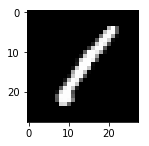

This is a 0


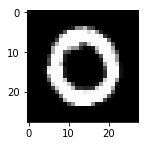

This is a 1


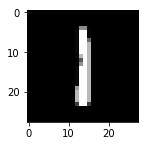

This is a 4


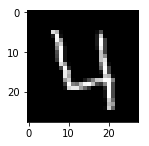

This is a 0


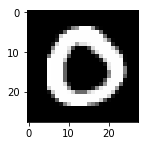

This is a 0


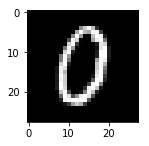

This is a 7


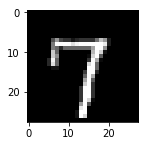

This is a 3


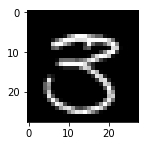

This is a 5


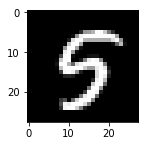

This is a 3


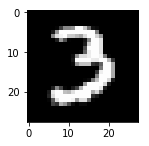

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2,10)

for i in range(0, 10):
    img = train.values[i][1:]
    label = train.values[i][0]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

In [7]:
train_data, validation_data, test_data = np.split(train.sample(frac=1, random_state=1728),[int(0.7 * len(train)), int(0.9 * len(train))])

In [8]:
train_data.to_csv('train_data.csv', header=False, index=False)
validation_data.to_csv('validation_data.csv', header=False, index=False)

In [9]:
s3_client.put_object(Bucket=bucket, Key=prefix + "/train_data.csv", Body=open('train_data.csv', 'rb'))


{'ResponseMetadata': {'RequestId': 'AA7D6C866AF694F5',
  'HostId': 'OmVQ7HYqwtunPQabxHfCy8yHBpcEcdrFAkhrZoNWuta6sG5HZ7XlrOcoqq7y+zP6TrhJ7rHshc8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'OmVQ7HYqwtunPQabxHfCy8yHBpcEcdrFAkhrZoNWuta6sG5HZ7XlrOcoqq7y+zP6TrhJ7rHshc8=',
   'x-amz-request-id': 'AA7D6C866AF694F5',
   'date': 'Sun, 09 Jun 2019 11:41:22 GMT',
   'etag': '"2687633af2c4d95e2872b9a81a564f91"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"2687633af2c4d95e2872b9a81a564f91"'}

In [10]:
s3_client.put_object(Bucket=bucket, Key=prefix + "/validation_data.csv", Body=open('validation_data.csv', 'rb'))

{'ResponseMetadata': {'RequestId': '04CC75897A919FB1',
  'HostId': 'Kh5+8oWBr2F6Lne/REBVciMFgEBeArrrwXzH+VEpnxTeYEqMaCXrAxDyVU8sjeE0EgUqj9BNn6Y=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Kh5+8oWBr2F6Lne/REBVciMFgEBeArrrwXzH+VEpnxTeYEqMaCXrAxDyVU8sjeE0EgUqj9BNn6Y=',
   'x-amz-request-id': '04CC75897A919FB1',
   'date': 'Sun, 09 Jun 2019 11:41:23 GMT',
   'etag': '"944be9d2b91920a4dab081df36beec6e"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"944be9d2b91920a4dab081df36beec6e"'}

In [11]:
import sagemaker

from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [13]:
s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model_sdk')

In [14]:
xgb_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.m4.xlarge',
                                         train_volume_size = 5,
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())

In [15]:
xgb_model.set_hyperparameters(max_depth = 5,
                              eta = .2,
                              gamma = 4,
                              min_child_weight = 6,
                              silent = 0,
                              objective = "multi:softmax",
                              num_class = 10,
                              num_round = 10)

In [17]:
train_channel = sagemaker.session.s3_input('s3://{}/{}/{}'.format(bucket, prefix, "train_data.csv"), content_type='text/csv')
valid_channel = sagemaker.session.s3_input('s3://{}/{}/{}'.format(bucket, prefix, "validation_data.csv"), content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

In [18]:
xgb_model.fit(inputs=data_channels,  logs=True)


2019-06-09 11:42:19 Starting - Starting the training job...
2019-06-09 11:42:21 Starting - Launching requested ML instances......
2019-06-09 11:43:29 Starting - Preparing the instances for training......
2019-06-09 11:44:50 Downloading - Downloading input data
2019-06-09 11:44:50 Training - Downloading the training image..
Arguments: train
[2019-06-09:11:45:01:INFO] Running standalone xgboost training.
[2019-06-09:11:45:01:INFO] File size need to be processed in the node: 65.86mb. Available memory size in the node: 8404.63mb
[2019-06-09:11:45:01:INFO] Determined delimiter of CSV input is ','
[11:45:01] S3DistributionType set as FullyReplicated
[11:45:02] 29399x784 matrix with 23048816 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-06-09:11:45:02:INFO] Determined delimiter of CSV input is ','
[11:45:02] S3DistributionType set as FullyReplicated
[11:45:02] 8401x784 matrix with 6586384 entries loaded from /opt/ml/input/data/validation?format=csv&l

In [19]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                                instance_type='ml.m4.xlarge',
                                )


----------------------------------------------------------------------------------------!

In [20]:
response = s3_client.get_object(Bucket=bucket, Key=prefix + "/test.csv")
response_body = response["Body"].read()
test = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)
test.to_csv('test.csv', header=False, index=False)


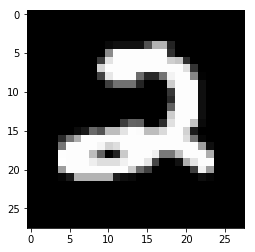

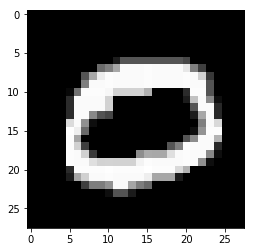

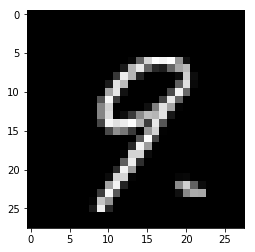

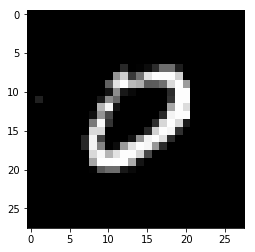

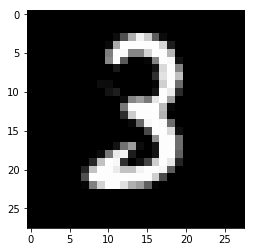

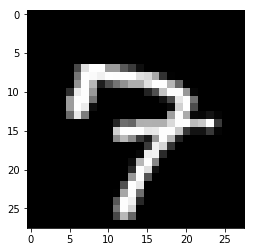

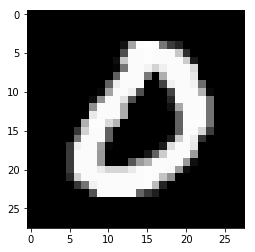

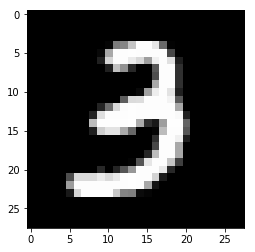

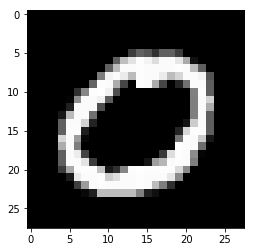

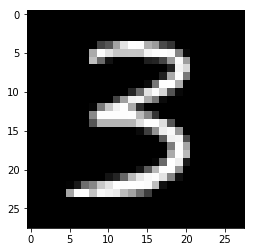

In [21]:
%matplotlib inline
                        
for i in range (0, 10):
    img = test.values[i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    plt.show()

In [81]:
test.shape[0]

result_df = pd.DataFrame([], columns=['ImageId','Label'])

with open('test.csv', 'r') as f:
    for j in range(1,test.shape[0] + 1):
        single_test = f.readline()
        result = xgb_predictor.predict(single_test)
        row = pd.DataFrame([j, int(float(result))], index=result_df.columns).T
        result_df = result_df.append(row)

In [83]:
result_df.head()

,ImageId,Label
0,1,2
0,2,0
0,3,9
0,4,4
0,5,3


In [88]:
result_df.set_index('ImageId').to_csv("./digit-recognizer_xgb_01.csv")